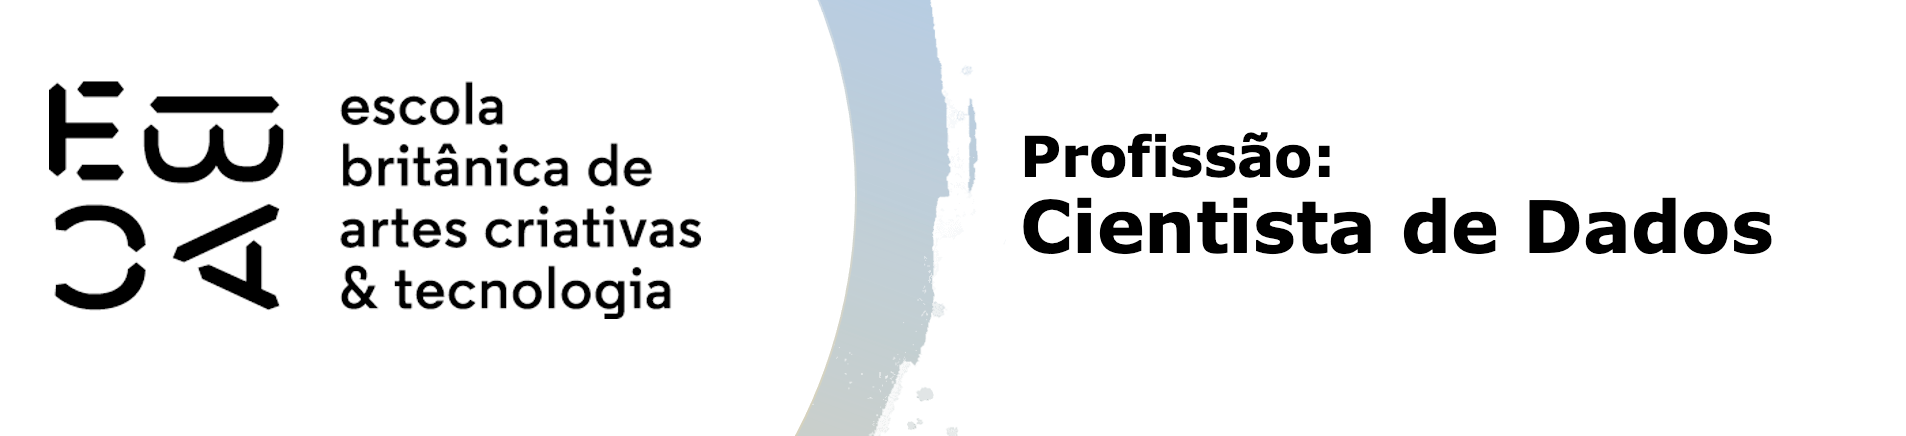

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [96]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

df = pd.read_csv('../Mod_32/previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [53]:
# Substituindo missings pela média
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          750000 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

In [54]:
df['data_ref'] = pd.to_datetime(df['data_ref'])
df['data_ref']

0        2015-01-01
1        2015-01-01
2        2015-01-01
3        2015-01-01
4        2015-01-01
            ...    
749995   2016-03-01
749996   2016-03-01
749997   2016-03-01
749998   2016-03-01
749999   2016-03-01
Name: data_ref, Length: 750000, dtype: datetime64[ns]

In [55]:
df['mes'] = df['data_ref'].dt.month
df['mes']

0         1
1         1
2         1
3         1
4         1
         ..
749995    3
749996    3
749997    3
749998    3
749999    3
Name: mes, Length: 750000, dtype: int32

In [56]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].map({classe: idx for idx, classe in enumerate(df[col].unique())})
    else:
        continue

df.head(5)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mes
0,2015-01-01,5762,0,0,0,0,0,0,0,0,47,16.717808,2.0,11138.14,1
1,2015-01-01,1279,0,0,0,0,1,1,0,0,30,9.600000,2.0,2424.81,1
2,2015-01-01,14111,0,0,0,0,1,0,0,0,28,8.208219,2.0,13749.66,1
3,2015-01-01,8189,0,1,1,2,1,2,0,0,44,1.301370,4.0,2361.84,1
4,2015-01-01,1830,1,1,1,2,1,0,0,0,33,1.254795,4.0,790.78,1


In [57]:
# Dividindo base de dados em bases de treino e teste
X = df.drop(['renda', 'data_ref', 'index'], axis=1)
y = df['renda']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=412)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

df_train.head(5)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,mes,renda
425276,1,1,0,0,1,0,4,0,51,4.931507,1.0,9,7660.01
344487,1,1,1,1,1,2,1,0,40,2.378082,2.0,7,12379.56
325594,1,1,1,1,0,0,0,0,45,6.090411,3.0,7,17267.22
561248,0,0,1,1,1,0,0,1,42,0.438356,3.0,12,4694.79
46307,1,1,1,0,2,2,0,0,57,7.746165,2.0,1,944.26


In [58]:
reg = smf.ols('np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia', 
              data=df_train).fit()

print(f'R² Ajustado: {reg.rsquared_adj:.2%}')

R² Ajustado: 38.34%


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [59]:
df_train['resid'] = reg.resid
df_train['fitted_values'] = reg.fittedvalues
df_train[['resid', 'fitted_values']].head(5)

,resid,fitted_values
425276,0.478240,8.465529
344487,1.060230,8.363572
325594,0.931995,8.824570
561248,0.206135,8.248074
46307,-2.138667,8.989068


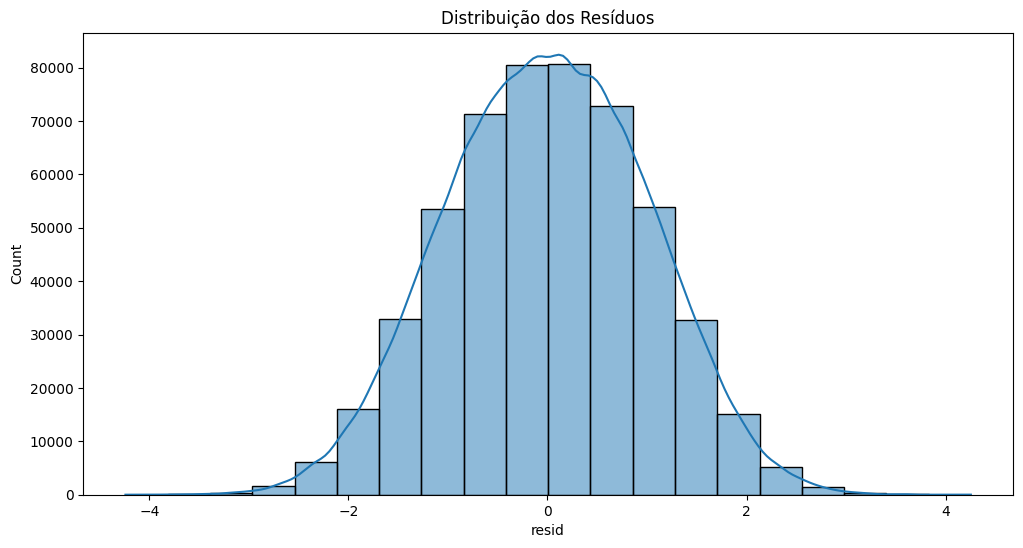

In [60]:
# 1. Verificação da normalidade dos resíudos
plt.figure(figsize=(12,6))
sns.histplot(df_train['resid'], kde=True, bins=20)
plt.title('Distribuição dos Resíduos')
plt.show()

In [61]:
# Teste de Shapiro-Wilk
stat, p_value = stats.shapiro(df_train['resid'])
print(f'Estatística de teste: {stat}, p-value: {p_value}')

Estatística de teste: 0.9988130730807009, p-value: 5.619946825359124e-39


D:\Anaconda\envs\myenv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 525000.
  res = hypotest_fun_out(*samples, **kwds)


Conforme observado pelo gráfico acima, os resíduos do modelo possuem uma distribuição normal. Confirmando essa observação visual, o **Teste de Shapiro-Wilk** retornou um *p-value* menor que 0.05, portanto corraborando com a normalidade da distribuição dos resíduos do modelo.

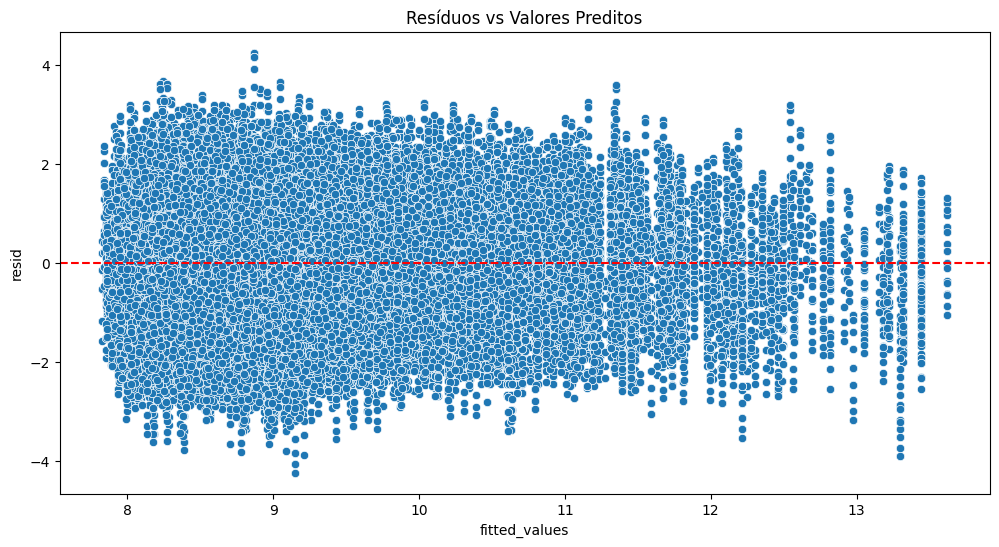

In [62]:
# 2. Independência dos resíduos
plt.figure(figsize=(12,6))
sns.scatterplot(x=df_train['fitted_values'], y=df_train['resid'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos vs Valores Preditos')
plt.show()

In [63]:
# Teste de Durbin-Watson para Validar Independência dos Resíduos
dw_stat = durbin_watson(df_train['resid'])
print(f'Estatística de Durbin-Watson: {dw_stat}')

Estatística de Durbin-Watson: 1.9988059624355359


In [64]:
# Criando matriz com variáveis independentes e constante
X_matriz = df_train[reg.params.index[1:]].copy()
X_matriz['intercept'] = reg.params.iloc[0].copy()
X_matriz

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,intercept
425276,1,1,0,0,0,51,4.931507,1.0,8.198112
344487,1,1,1,1,0,40,2.378082,2.0,8.198112
325594,1,1,1,1,0,45,6.090411,3.0,8.198112
561248,0,0,1,1,1,42,0.438356,3.0,8.198112
46307,1,1,1,0,0,57,7.746165,2.0,8.198112
...,...,...,...,...,...,...,...,...,...
614673,1,0,0,1,0,39,6.898630,3.0,8.198112
249506,1,0,0,2,0,43,20.189041,4.0,8.198112
598885,1,0,1,0,0,61,9.605479,2.0,8.198112
12172,1,0,1,1,0,35,6.383562,2.0,8.198112


In [65]:
# Teste de Breusch-Pagan para Validar a Homocedasticidade dos Resíduos
_, pval, _, _ = het_breuschpagan(df_train['resid'], X_matriz)
print(f'P-value do teste de Breusch-Pagan: {pval}')

P-value do teste de Breusch-Pagan: 8.797620294591551e-36


Como podemos observar pelo gráfico e pelos testes de independência (Durbin-Watson) e homocedasticidade (Breusch-Pagan), os resíduos do modelo são **independentes**, mas não são **identicamente distribuídos**. O que pode corrabora com o gráfico visto acima.

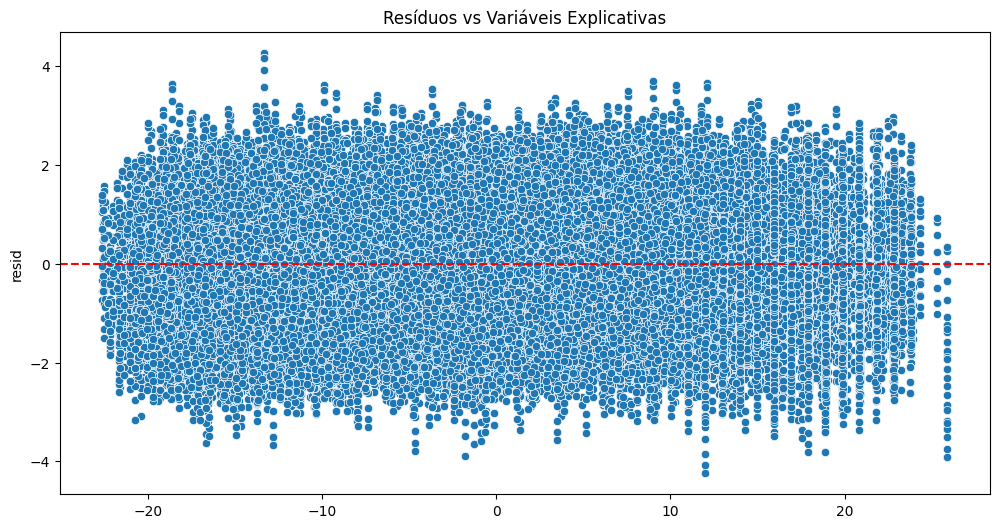

In [66]:
# 3. Padrões dos resíduos vs variáveis independentes

# Combinação linear das variáveis explicativas do modelo em um array unidimensional
pca = (PCA(n_components=1)
       .fit_transform(df_train[['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']])
       .flatten())

# Visualizando gráfico
plt.figure(figsize=(12,6))
sns.scatterplot(x=pca, y=df_train['resid'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos vs Variáveis Explicativas')
plt.show()

In [67]:
# Função para plotar gráfico
def plotar_grafico_variavel_explicativa_vs_residuo(var):
    plt.figure(figsize=(12,6))
    sns.scatterplot(x=df_train[var], y=df_train['resid'])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Resíduos vs Variável {}'.format(var))
    plt.show()

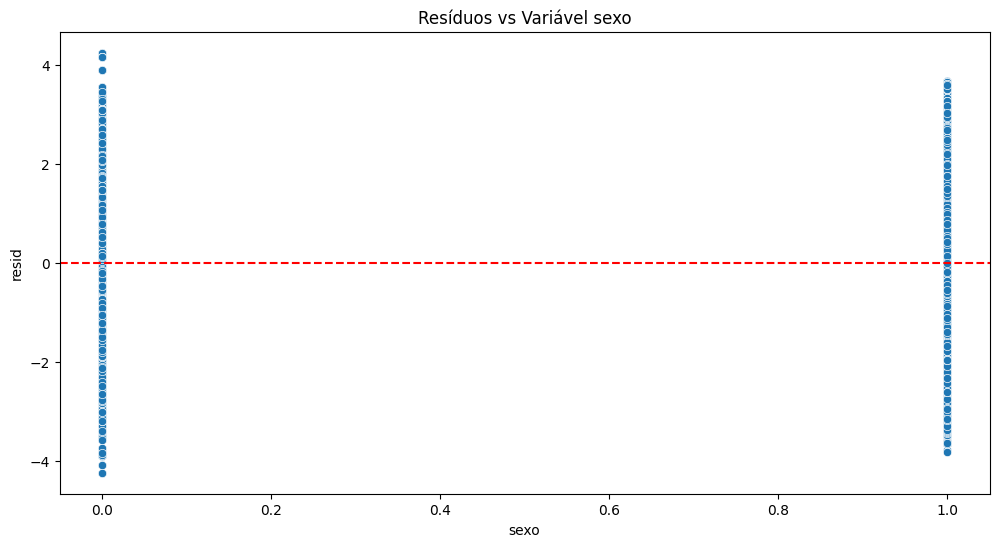

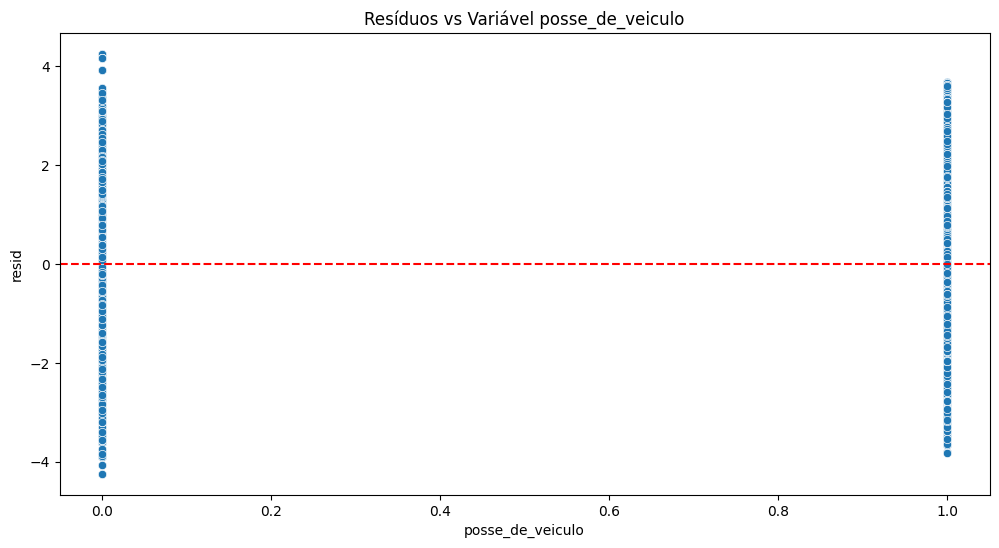

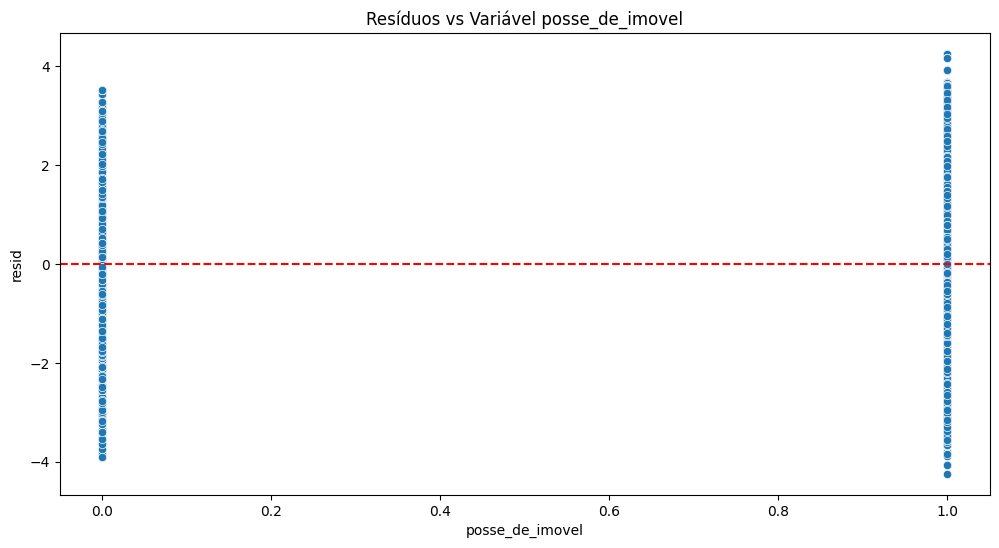

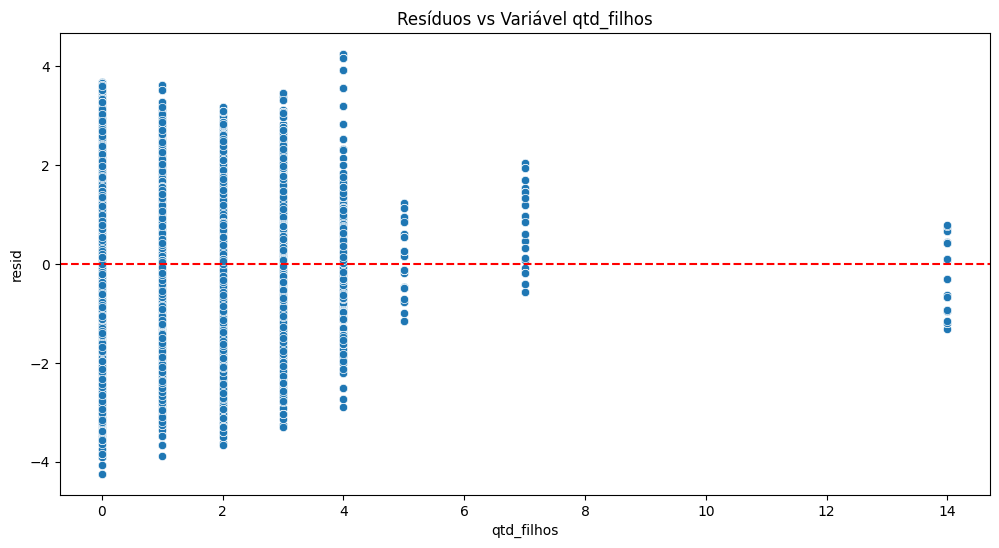

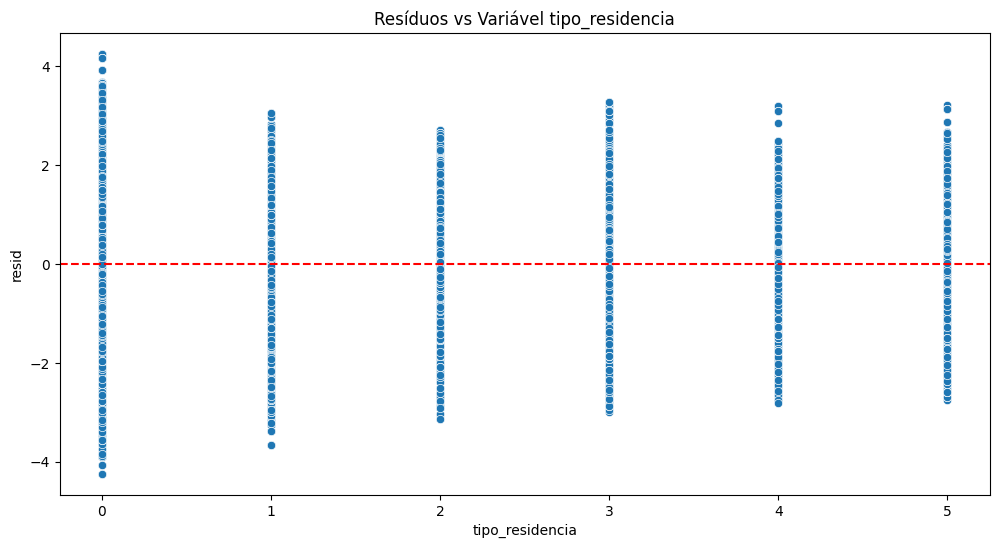

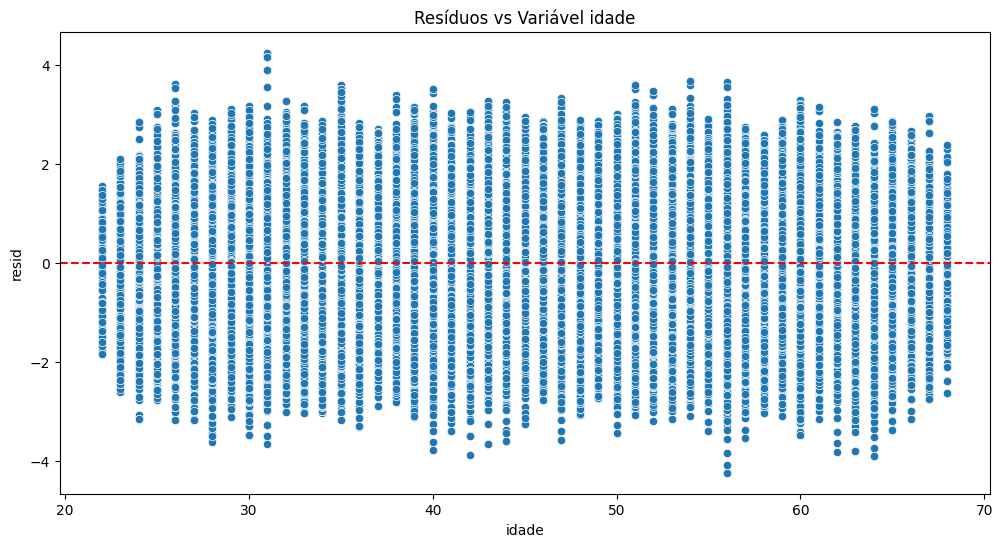

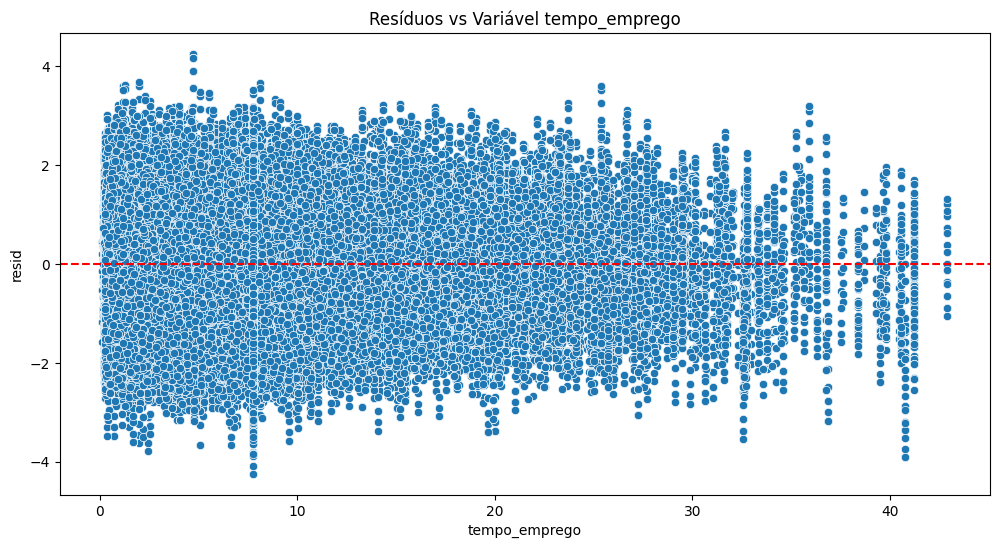

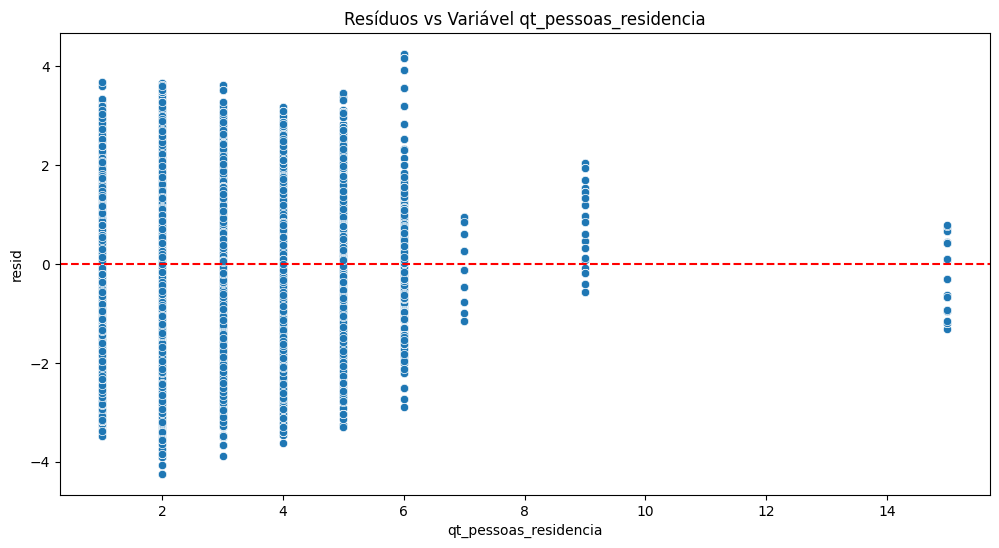

In [68]:
for var in ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']:
    plotar_grafico_variavel_explicativa_vs_residuo(var)

Observando pelos gráficos acima, as variáveis explicativas não parecem demonstrar nenhum padrão em sua distribuição afetado pelos resíduos, portanto podemos considerar os resíduos **independentes**.

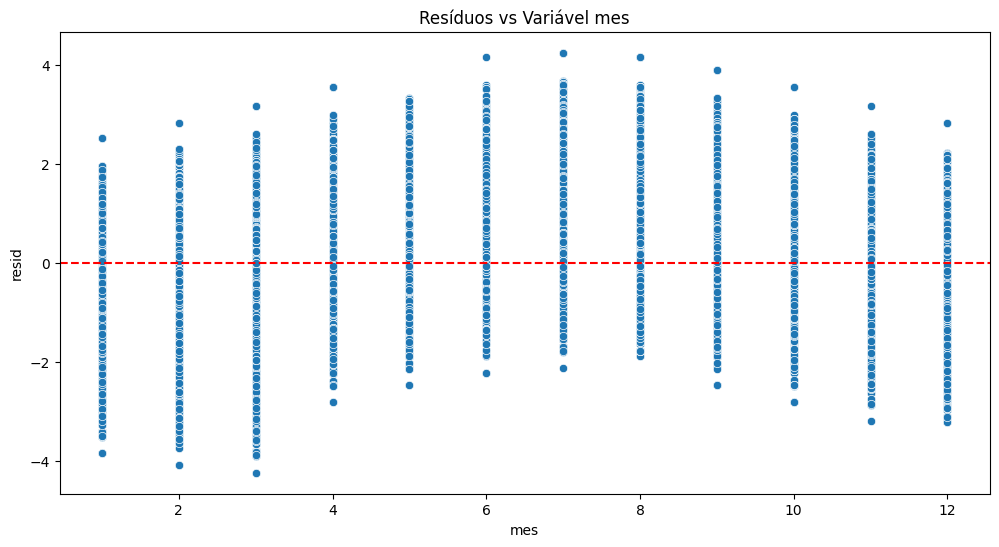

In [69]:
# Avaliando se valor médio dos resíduos é afetado pelo mês de referencia
plotar_grafico_variavel_explicativa_vs_residuo('mes')

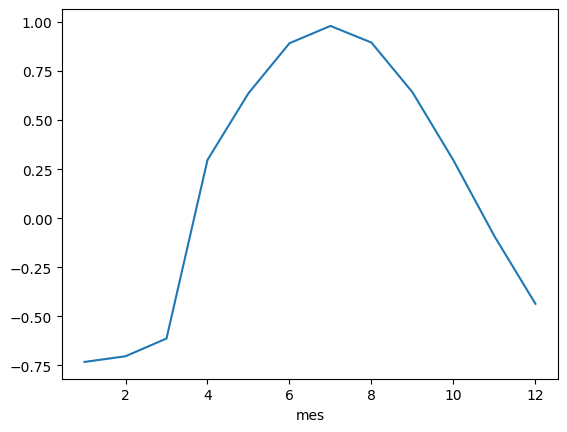

In [70]:
gp = df_train.groupby(by='mes')['resid'].mean()
gp.plot.line()
plt.show()

Observando pelos gráficos acima, de fato os resíduos do modelo são afetados pela variável explicativa **mes**, contudo, como excluímos essa variável do modelo, esse permanece inafetado por essa propriedade.

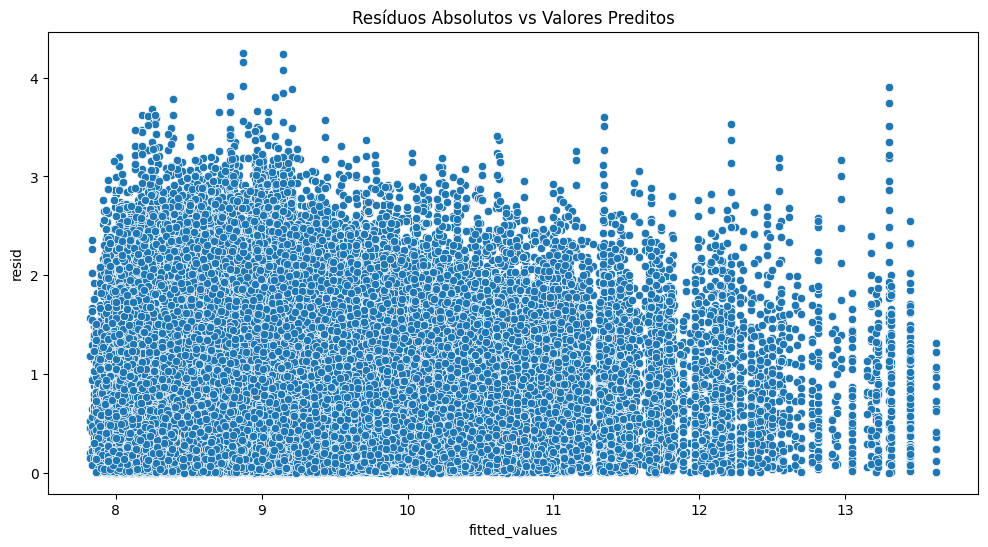

In [71]:
# 4. Homocedasticidade (variância da variável resposta com valores preditos)
plt.figure(figsize=(12,6))
sns.scatterplot(x=df_train['fitted_values'], y=np.abs(df_train['resid']))
plt.title('Resíduos Absolutos vs Valores Preditos')
plt.show()

Observando o gráfico acima, os valores não estão distribuídos de forma igual ao longo do eixo de **fitted_values**, o que leva a mesma conclusão vista mais acima, a **heterocedasticidade** do modelo.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

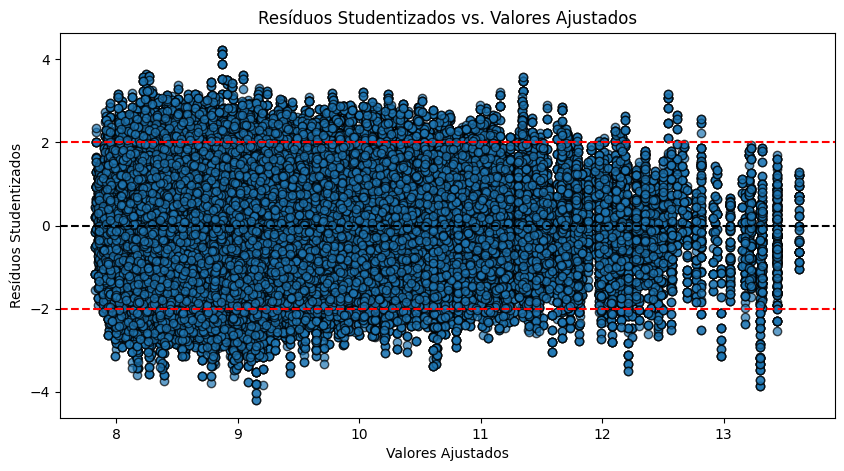

In [72]:
influence = OLSInfluence(reg)
studentized_residuals = influence.resid_studentized_internal

leverage = influence.hat_matrix_diag
cook_distance = influence.cooks_distance[0]

# Gráfico de resíduos studentizados vs. valores ajustados
plt.figure(figsize=(10, 5))
plt.scatter(df_train['fitted_values'], studentized_residuals, edgecolors='k', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axhline(y=2, color='red', linestyle='dashed')
plt.axhline(y=-2, color='red', linestyle='dashed')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos Studentizados')
plt.title('Resíduos Studentizados vs. Valores Ajustados')
plt.show()

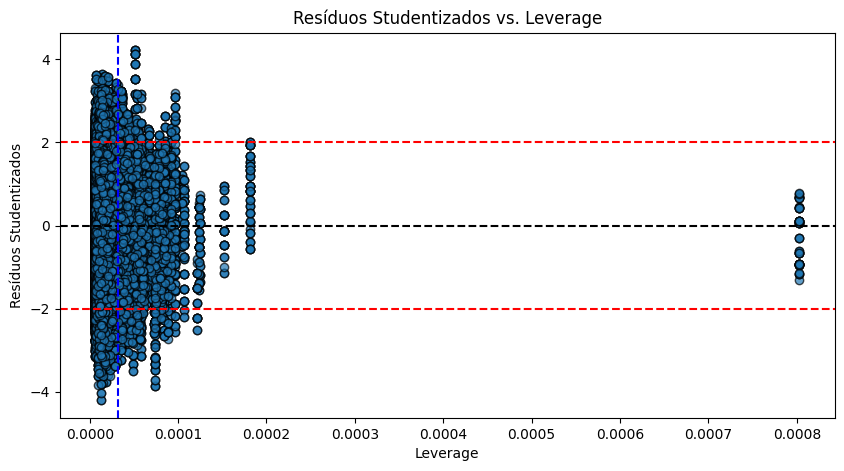

In [73]:
# Gráfico de leverage vs. resíduos studentizados
plt.figure(figsize=(10, 5))
plt.scatter(leverage, studentized_residuals, edgecolors='k', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axhline(y=2, color='red', linestyle='dashed')
plt.axhline(y=-2, color='red', linestyle='dashed')
plt.axvline(x=2 * (X.shape[1] / X.shape[0]), color='blue', linestyle='dashed')  
plt.xlabel('Leverage')
plt.ylabel('Resíduos Studentizados')
plt.title('Resíduos Studentizados vs. Leverage')
plt.show()

Como podemos observar nos gráficos acima, o modelo possui uma quantidade alta de **outliers** nos dados. Também existem muitos pontos influentes, essas características dos dados podem se tornar um problema no modelo, uma vez que a poder previsório do mesmo é afetado por esses desvios de valores.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

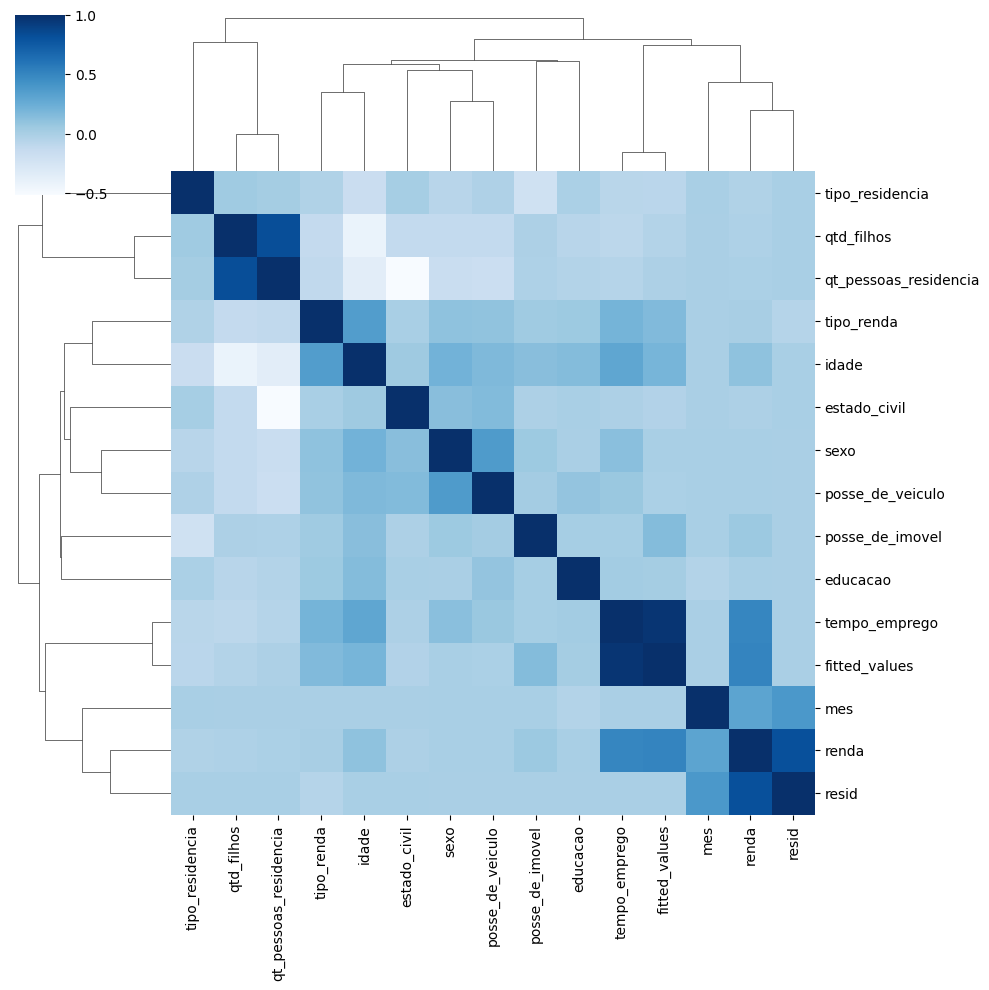

In [76]:
# Correlação de Spearman
corr = df_train.corr(method='spearman')
sns.clustermap(corr, cmap='Blues')
plt.show()

Observando pelo gráfico acima, podemos identificar pares de variáveis que possuem uma correlação alta entre si, segue abaixo a lista com as 10 variáveis que possuem o maior nível de correlação de acordo com a correlação de Spearman.

In [84]:
p_values = {}

for col in df_train.drop(['renda', 'resid', 'fitted_values'], axis=1).columns:
    correlation, p_value = stats.spearmanr(df_train[col], df_train['renda'])
    p_values[col] = (correlation, p_value)

p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['Spearman_Correlation', 'p_value'])
p_values_df = p_values_df.sort_values(by='Spearman_Correlation', key=abs, ascending=False)

p_values_df.head(10)

,Spearman_Correlation,p_value
tempo_emprego,0.501138,0.000000e+00
mes,0.310952,0.000000e+00
idade,0.107130,0.000000e+00
posse_de_imovel,0.062429,0.000000e+00
tipo_residencia,-0.033575,8.583317e-131
qtd_filhos,-0.018912,9.529504e-43
estado_civil,-0.012380,2.959120e-19
tipo_renda,0.012130,1.508720e-18
qt_pessoas_residencia,-0.007915,9.734349e-09
educacao,0.005369,1.002325e-04


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [86]:
reg_ajs = smf.ols('np.log(renda) ~ tempo_emprego + mes + idade + posse_de_imovel + tipo_residencia + qtd_filhos + estado_civil + tipo_renda + qt_pessoas_residencia + educacao',
                 data=df_train).fit()

print(f'R² Ajustado do Modelo Original: {reg.rsquared_adj:.2%}')
print(f'R² Ajustado do Novo Modelo: {reg_ajs.rsquared_adj:.2%}')

R² Ajustado do Modelo Original: 38.34%
R² Ajustado do Novo Modelo: 45.19%


In [97]:
# Testando na base de testes
y_pred1 = np.exp(reg.predict(X_test))
y_pred2 = np.exp(reg_ajs.predict(X_test))

# Calcular R² na base de teste
r2_1 = r2_score(y_test, y_pred1)
r2_2 = r2_score(y_test, y_pred2)

# Número de observações e número de variáveis independentes
n = df_test.shape[0]  
p1 = len(reg.params) - 1  
p2 = len(reg_ajs.params) - 1

# Calcular R² Ajustado na base de teste
r2_ajustado_teste_1 = 1 - ((1 - r2_1) * (n - 1) / (n - p1 - 1))
r2_ajustado_teste_2 = 1 - ((1 - r2_2) * (n - 1) / (n - p2 - 1))

# Exibir resultado
print(f'R² Ajustado na base de teste do Modelo Original: {r2_ajustado_teste_1:.2%}')
print(f'R² Ajustado na base de teste do Novo Modelo: {r2_ajustado_teste_2:.2%}')

R² Ajustado na base de teste do Modelo Original: 30.02%
R² Ajustado na base de teste do Novo Modelo: 32.58%


Conforme podemos observar, a alteração da seleção das variáveis do modelo com base no **p_value** calculado pela correlação de Spearman, permitiu criar um modelo mais apurado do que o anterior.

In [98]:
reg.params

Intercept                8.198112
sexo                    -0.125888
posse_de_veiculo        -0.027787
posse_de_imovel          0.185782
qtd_filhos               0.010904
tipo_residencia          0.005109
idade                   -0.004377
tempo_emprego            0.132414
qt_pessoas_residencia   -0.008681
dtype: float64

In [99]:
reg_ajs.params

Intercept                7.562508
tempo_emprego            0.132315
mes                      0.094290
idade                   -0.004091
posse_de_imovel          0.181815
tipo_residencia          0.010183
qtd_filhos              -0.004930
estado_civil             0.002491
tipo_renda              -0.060332
qt_pessoas_residencia    0.014261
educacao                 0.013782
dtype: float64